In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings(action = 'ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
#시각화를 위한 color 딕셔너리
color_dic = {0:['#005b6e','#04668c'],1:['#3c6ca7','#786eb7'],2:['#a86bba','#da66ac'],
             3:['#ff6792','#aa6792'],4:['#d8e0bb','#b6cec7'],5:['#ff5050','#ffaa00'],
            6:['#ff99ff','#ff6699',],7:['#e6f2ff','#99ccff'],8:['#ccccff','#cc99ff'],
            9:['#ff9966', '#ff6600']}

# Data Fields
- datetime - hourly date + timestamp  
- season 
        1 = spring
        2 = summer 
        3 = fall
        4 = winter 
- holiday - whether the day is considered a holiday (0,1)
- workingday - whether the day is neither a weekend nor holiday (0,1)
- weather 
        1: Clear, Few clouds, Partly cloudy, Partly cloudy
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

# Load Dataset

In [3]:
bike_df = pd.read_csv('./Bike/train.csv')

In [4]:
bike_df.shape

(10886, 12)

In [5]:
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


------
- casual + registered = count로 보인다. 


In [6]:
#count+registered인 데이터로 구성된 컬럼 생성
bike_df['c+r'] = bike_df['casual']+bike_df['registered']

In [7]:
bike_df[['c+r','count']].describe()

,c+r,count
count,10886.000000,10886.000000
mean,191.574132,191.574132
std,181.144454,181.144454
min,1.000000,1.000000
25%,42.000000,42.000000
50%,145.000000,145.000000
75%,284.000000,284.000000
max,977.000000,977.000000


-----
casual+registered 와 count는 완전히 같은 값이다.

<br>

In [8]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
 12  c+r         10886 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 1.1+ MB


In [9]:
bike_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,c+r
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,977.000000


---------
- 컬럼 'datetime'의 타입이 object이다. datetime 타입으로 바꿔야 할 것 같다.
- casual + registered = count이다. 따라서 굳이 필요하지 않은 컬럼이고, 오히려 상관도가 높아 예측을 저해할 우려가 있다.

<br><br>
# Data Preprocessing
- 불필요한 컬럼 삭제
- 타입 변환
- binning
- outlier 삭제
- 정규화 및 표준화

### datetime 컬럼 object -> datetime 

In [10]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)
#bike_df = pd.read_csv('./Bike/train.csv',parse_dates=['datetime'])  불러올때 parse_dates파라미터로도 바꿀 수 있음

In [11]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  c+r         10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(9)
memory usage: 1.1 MB


<br>

- datetime 쪼개기 -> year/month/day/hour

In [12]:
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)

In [13]:
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,c+r,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,2011,1,1,4


<br>

### 불필요한 컬럼(datetime, casual, registered, c+r) 삭제

In [14]:
bike_df.drop(['datetime', 'casual', 'registered', 'c+r'],axis=1 ,inplace = True)

In [15]:
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


<br><br>
### 데이터 분포 확인

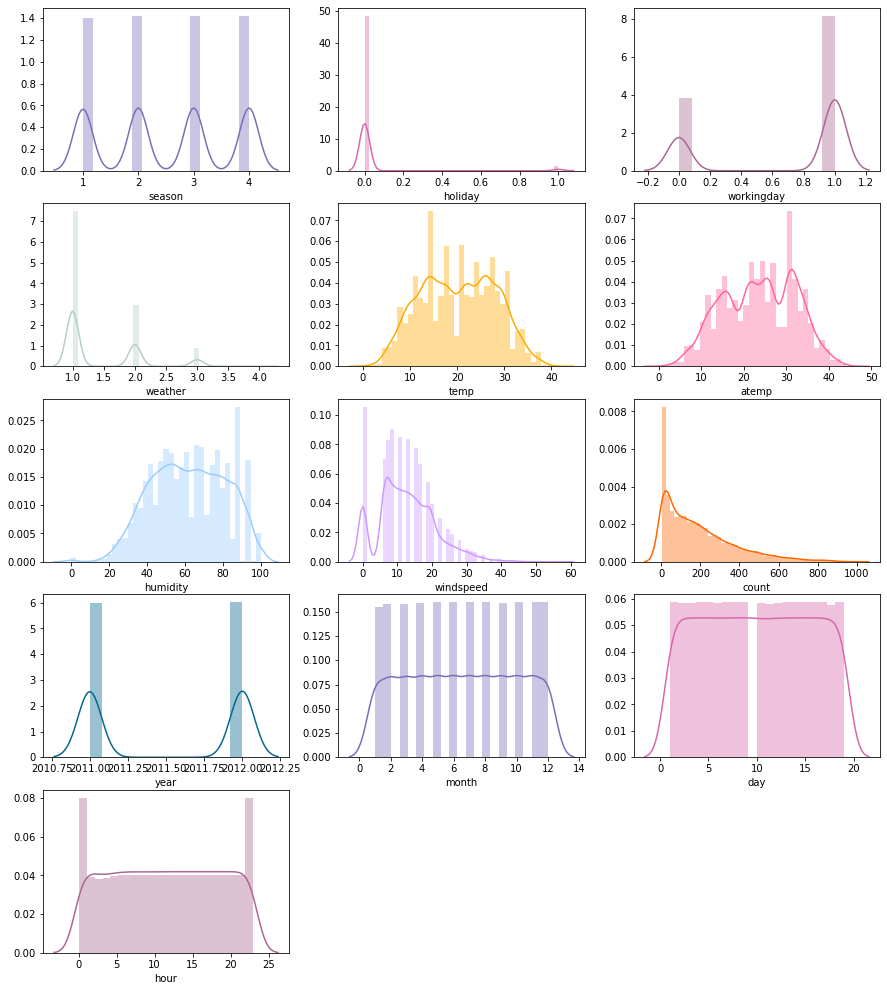

In [16]:
plt.figure(figsize=(15,15))
for e,c in enumerate(bike_df.columns[:],1):
    plt.subplot(5,3,e)
    plt.subplots_adjust(top=1)
    sns.distplot(bike_df[c],color=color_dic[e%10][1])

---------
- season/ holiday / workingday/ weather/ year / month / day /hour는 category 타입이다.<br>
*그냥 수치형 타입으로 두고 선형 회귀에 사용할 경우, 회귀 계수를 연산할 때 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다.(특히 값이 큰 year같은 경우)
<br><br>
- count 데이터는 정규분포가 아닌 0~200 사이에 왜곡돼 있다. -> 로그 변환을 적용해보자

- temp와 atemp의 분포 차이가 상당히 커보인다. 둘 중 어떤 컬럼이 count값에 더 영향을 주는지 알아봐야할 것 같다.

### count 컬럼 로그 변환

<AxesSubplot:>

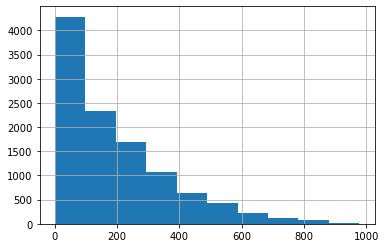

In [17]:
bike_df['count'].hist()

<AxesSubplot:>

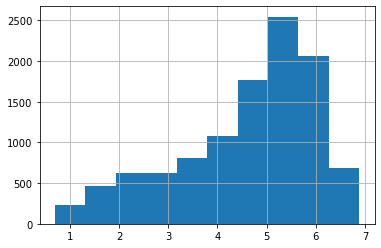

In [18]:
np.log1p(bike_df['count']).hist()

In [19]:
bike_df['log_count'] = np.log1p(bike_df['count'])

In [20]:
bike_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,log_count
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,2.833213
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,3.713572
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,3.496508
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,2.639057
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,5.820083
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,5.488938
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,5.129899
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,4.867534


-----
로그 변환 후에도 정규 분포는 아니지만 왜곡이 어느정도는 완화되었다.

<br>

### category 타입 변환 + one-hot encoding

In [21]:
categorical_dat = ['season', 'holiday','workingday','weather','year','month','day','hour']

In [22]:
one_hot_df = pd.get_dummies(bike_df.loc[:,categorical_dat].astype('category'))

In [23]:
one_hot_df

,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
10882,0,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
10883,0,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
10884,0,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
one_tmp = pd.DataFrame(bike_df.drop(categorical_dat, axis=1).iloc[:,:], columns = bike_df.drop(categorical_dat, axis=1).columns)

In [25]:
one_tmp

,temp,atemp,humidity,windspeed,count,log_count
0,9.84,14.395,81,0.0000,16,2.833213
1,9.02,13.635,80,0.0000,40,3.713572
2,9.02,13.635,80,0.0000,32,3.496508
3,9.84,14.395,75,0.0000,13,2.639057
4,9.84,14.395,75,0.0000,1,0.693147
...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,336,5.820083
10882,14.76,17.425,57,15.0013,241,5.488938
10883,13.94,15.910,61,15.0013,168,5.129899
10884,13.94,17.425,61,6.0032,129,4.867534


In [26]:
#concatenate
one_hot_df = pd.concat([one_tmp, one_hot_df],axis=1)

In [27]:
one_hot_df

,temp,atemp,humidity,windspeed,count,log_count,season_1,season_2,season_3,season_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,14.395,81,0.0000,16,2.833213,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,13.635,80,0.0000,40,3.713572,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,13.635,80,0.0000,32,3.496508,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,14.395,75,0.0000,13,2.639057,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,14.395,75,0.0000,1,0.693147,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,336,5.820083,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
10882,14.76,17.425,57,15.0013,241,5.488938,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
10883,13.94,15.910,61,15.0013,168,5.129899,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
10884,13.94,17.425,61,6.0032,129,4.867534,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


<br><br><br>

# EDA

### 수치형 컬럼들과 count컬럼의 상관 관계

- temp

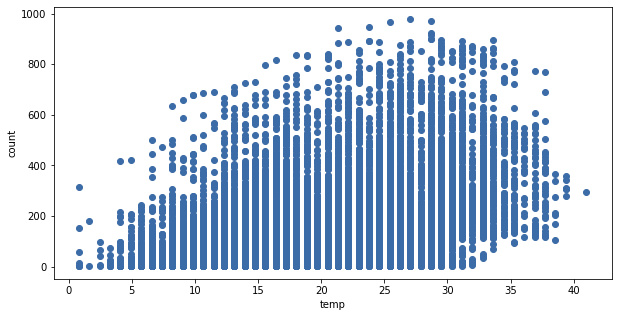

In [28]:
plt.figure(figsize=(10,5))
plt.xlabel('temp')
plt.ylabel('count')
plt.scatter(y=bike_df['count'], x= bike_df['temp'],color=color_dic[1][0])
plt.show()

- atemp

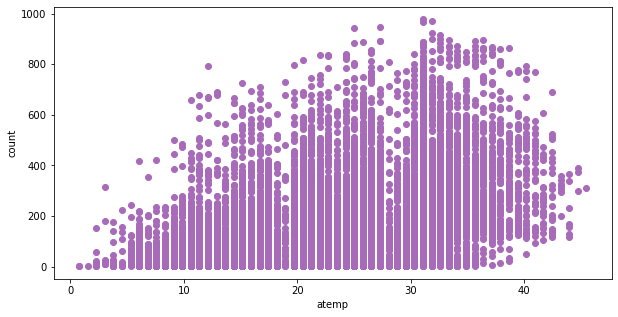

In [29]:
plt.figure(figsize=(10,5))
plt.xlabel('atemp')
plt.ylabel('count')
plt.scatter(y=bike_df['count'], x= bike_df['atemp'],color=color_dic[2][0])
plt.show()

- temp & atemp

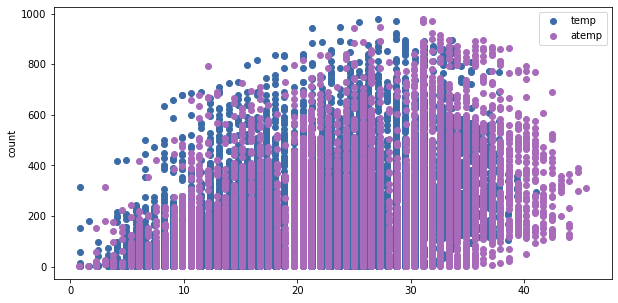

In [30]:
plt.figure(figsize=(10,5))
plt.ylabel('count')
plt.scatter(y=bike_df['count'], x= bike_df['temp'],color=color_dic[1][0], label='temp')
plt.scatter(y=bike_df['count'], x= bike_df['atemp'],color=color_dic[2][0], label='atemp')
plt.legend()
plt.show()

-------
temp와 atemp의 분포와 각 값에 따른 count값도 차이가 있는 것으로 보인다. 이후에 temp와 atemp의 차이를 알아봐야겠다.

- humidity

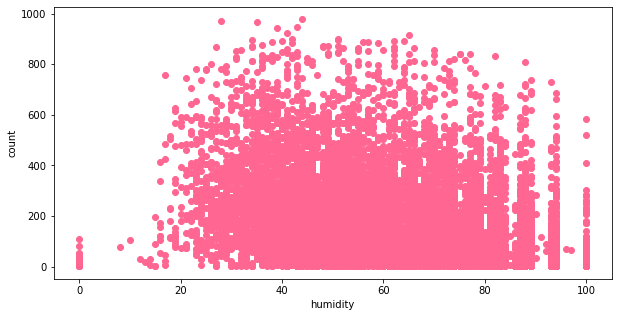

In [31]:
plt.figure(figsize=(10,5))
plt.xlabel('humidity')
plt.ylabel('count')
plt.scatter(y=bike_df['count'], x= bike_df['humidity'],color=color_dic[3][0])
plt.show()

- windspeed

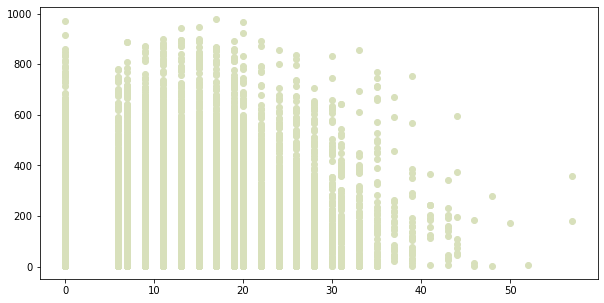

In [32]:
plt.figure(figsize=(10,5))
plt.scatter(y=bike_df['count'], x= bike_df['windspeed'],color=color_dic[4][0])
plt.show()

<br>

- 수치형 컬럼들의 상관 계수

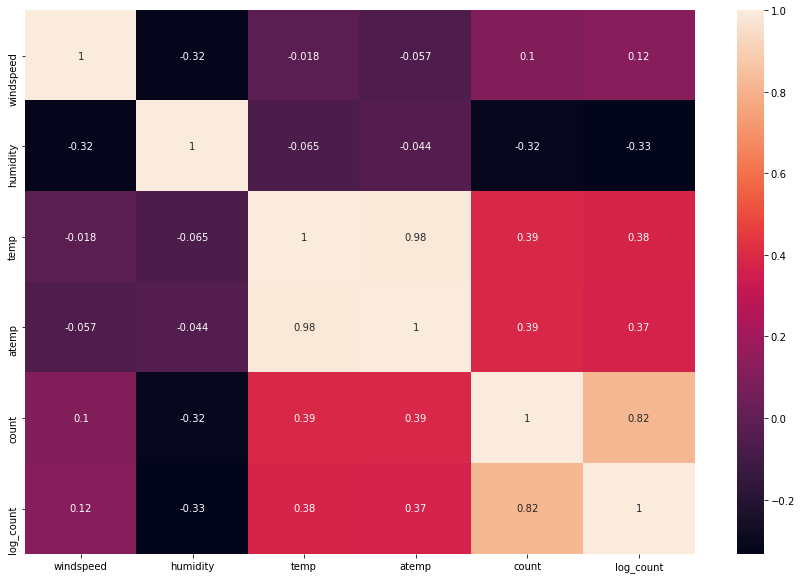

In [33]:
plt.figure(figsize=(15,10))
sns.heatmap(bike_df[['windspeed', 'humidity','temp', 'atemp','count','log_count']].corr(),annot= True)
plt.show()

-----------
상관 계수가 유의미하게 크거나 작은 값은 없어보인다.<br>
낮은 수치지만,<br>
count, log_count와 양의 관계를 보이는 컬럼은 atemp와 temp컬럼이 있고,<br>
음의 관계를 보이는 컬럼은 humidity 컬럼이 있다고 볼 수 있겠다.<br>
atemp와 temp 그리고 log_count와 count를 제외하고는 서로 상관성을 보이는 컬럼은 없는 것 같다.

<br><br>

### temp와 atemp의 차이

실제 온도와 체감 온도(atemp)의 차이에 대해 알아보자.

Text(0, 0.5, 'atemp')

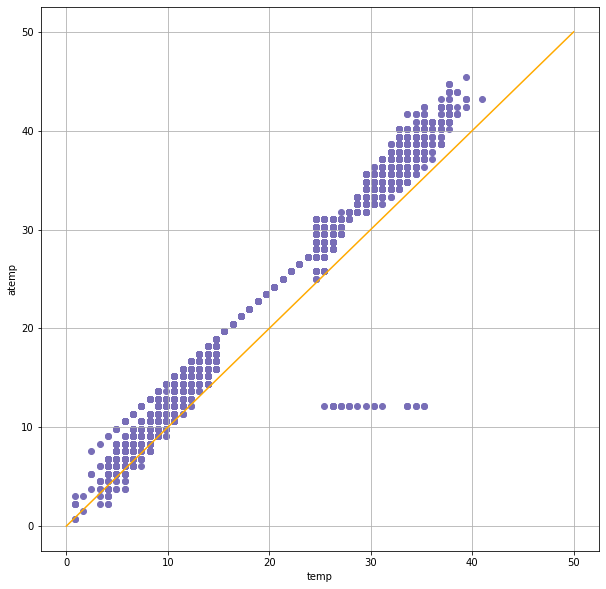

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(y=bike_df['atemp'], x= bike_df['temp'],color=color_dic[1][1])
plt.plot([0,50],[0,50],color=color_dic[5][1])
plt.grid(True)
plt.xlabel('temp')
plt.ylabel('atemp')

----------
temp와 atemp가 동일한 경우가 온도가 높아질수록 드물다.<br> atemp가 현저히 낮을 때(temp가 25~35일 때의 소수 데이터)도 있지만 대부분 atemp가 temp보다 높다.
<br><br>

In [35]:
tmp =pd.DataFrame() 
tmp['temp'] = bike_df['temp']
tmp['atemp'] =bike_df['atemp']
tmp['temp_error'] = abs(bike_df['temp']-bike_df['atemp'])

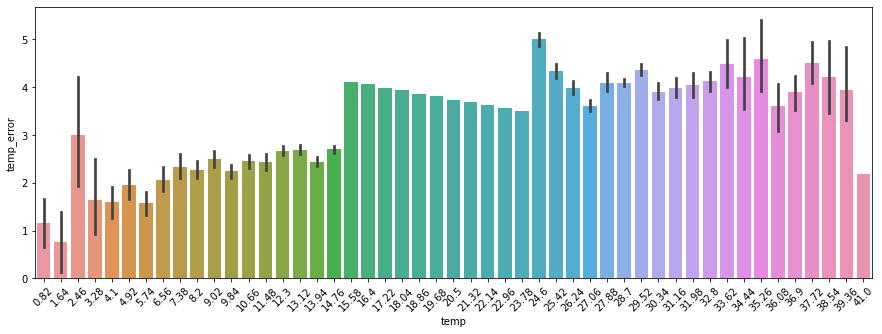

In [36]:
plt.figure(figsize=(15,5))
sns.barplot(x = tmp['temp'], y= tmp['temp_error'])
plt.xticks(rotation=45)
plt.show()

--------
binning을 수행해서 구간별로 알아보는 것이 좋을 것 같다.<br><br>

- temp ,atemp 4구간으로 나누기

In [37]:
tmp['temp_4'] = pd.qcut(tmp['temp'],4)
tmp['atemp_4'] = pd.qcut(tmp['atemp'],4)

In [38]:
tmp['temp_4'].value_counts()

(0.819, 13.94]    2926
(13.94, 20.5]     2709
(26.24, 41.0]     2642
(20.5, 26.24]     2609
Name: temp_4, dtype: int64

In [39]:
tmp['atemp_4'].value_counts()

(24.24, 31.06]     2998
(0.759, 16.665]    2935
(16.665, 24.24]    2724
(31.06, 45.455]    2229
Name: atemp_4, dtype: int64

- temp_4를 기준으로 grouping

In [40]:
tmp.groupby('temp_4').mean()

,temp,atemp,temp_error
temp_4,,,
"(0.819, 13.94]",10.483725,12.846635,2.391369
"(13.94, 20.5]",17.415843,21.136405,3.720561
"(20.5, 26.24]",23.864232,27.787489,3.987574
"(26.24, 41.0]",30.324171,34.127142,4.058066


-------
기온이 낮은 구간에서는 temp_error평균이 2.5미만으로 상대적으로 낮고, 나머지는 평균 3.5이상이다.<br>
그리고 각 구간에서 temp값의 평균보다 atemp값의 평균이 항상 높다.<br><br>

<br>

- outlier 제거(3분위수 + 1 이상인 값 제거)

In [41]:
tmp.drop(tmp.loc[tmp['temp_error'] >tmp['temp_error'].quantile(0.75)+1].index, inplace=True) #outlier 제거

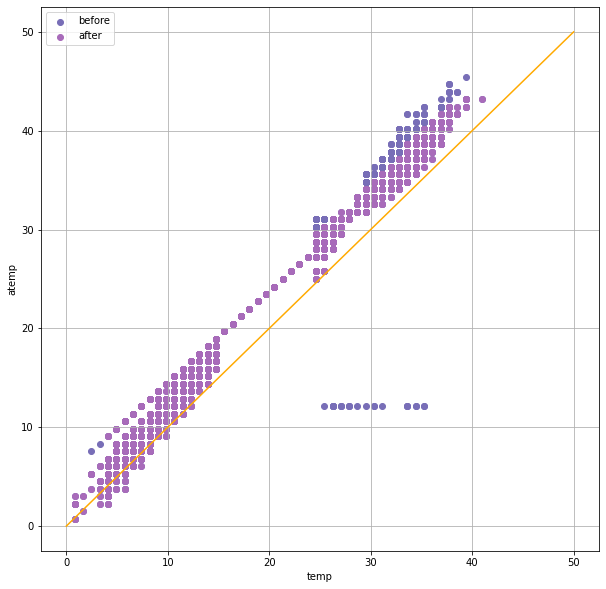

In [42]:
plt.figure(figsize=(10,10))
plt.scatter(y=bike_df['atemp'], x= bike_df['temp'],color=color_dic[1][1],label='before')
plt.scatter(y=tmp['atemp'], x= tmp['temp'],color=color_dic[2][0],label='after')
plt.plot([0,50],[0,50],color=color_dic[5][1])
plt.grid(True)
plt.legend()
plt.xlabel('temp')
plt.ylabel('atemp')
plt.show()

-------
너무 동떨어진 값들을 제거했다.

<br>

- 실제 데이터에 적용

In [43]:
bike_df['temp_error'] = abs(bike_df['temp'] - bike_df['atemp'])

In [44]:
bike_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,log_count,temp_error
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,2.833213,4.555
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,3.713572,4.615
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,3.496508,4.615
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,2.639057,4.555
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,0.693147,4.555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,5.820083,4.115
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,5.488938,2.665
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,5.129899,1.970
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,4.867534,3.485


In [45]:
bike_df.drop(bike_df.loc[bike_df['temp_error'] >bike_df['temp_error'].quantile(0.75)+1].index, inplace=True)

In [46]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10143 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10143 non-null  int64  
 1   holiday     10143 non-null  int64  
 2   workingday  10143 non-null  int64  
 3   weather     10143 non-null  int64  
 4   temp        10143 non-null  float64
 5   atemp       10143 non-null  float64
 6   humidity    10143 non-null  int64  
 7   windspeed   10143 non-null  float64
 8   count       10143 non-null  int64  
 9   year        10143 non-null  int64  
 10  month       10143 non-null  int64  
 11  day         10143 non-null  int64  
 12  hour        10143 non-null  int64  
 13  log_count   10143 non-null  float64
 14  temp_error  10143 non-null  float64
dtypes: float64(5), int64(10)
memory usage: 1.2 MB


<br><br>

### 시간과  자전거 수요의 상관 관계

- 계절 기준

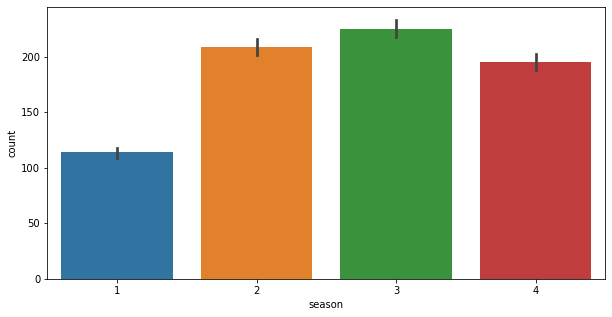

In [47]:
plt.figure(figsize=(10,5))
sns.barplot(y=bike_df['count'], x=bike_df['season'])
plt.show()

- year기준

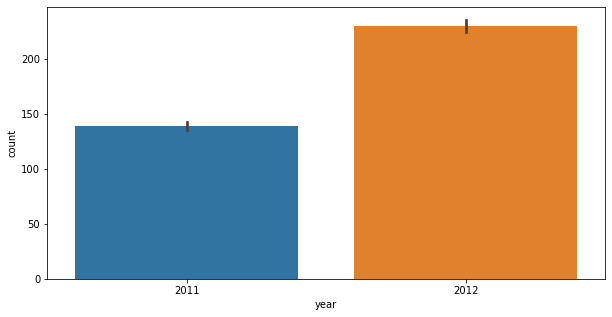

In [48]:
plt.figure(figsize=(10,5))
sns.barplot(y=bike_df['count'], x=bike_df['year'])
plt.show()

- month기준

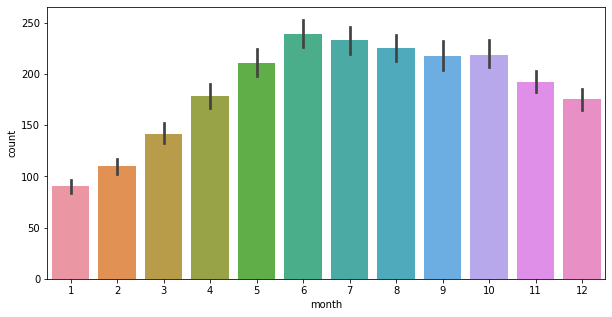

In [49]:
plt.figure(figsize=(10,5))
sns.barplot(y=bike_df['count'], x=bike_df['month'])
plt.show()

- day기준

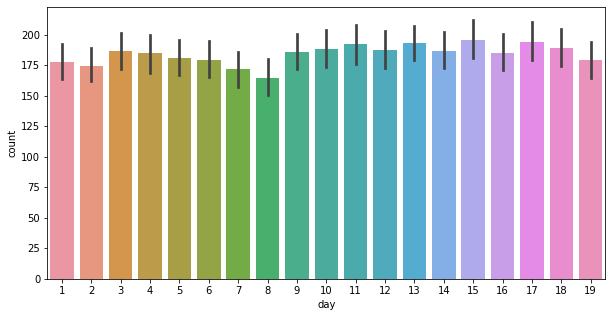

In [50]:
plt.figure(figsize=(10,5))
sns.barplot(y=bike_df['count'], x=bike_df['day'])
plt.show()

- hour기준

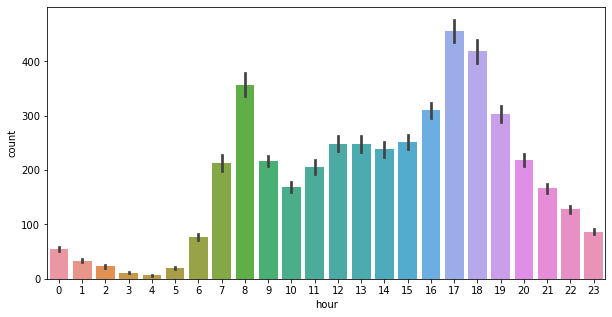

In [51]:
plt.figure(figsize=(10,5))
sns.barplot(y=bike_df['count'], x=bike_df['hour'])
plt.show()

- season + year

In [52]:
season_year_df = pd.DataFrame(bike_df.groupby(['season', 'year'], sort=True)['count'].mean()).reset_index()

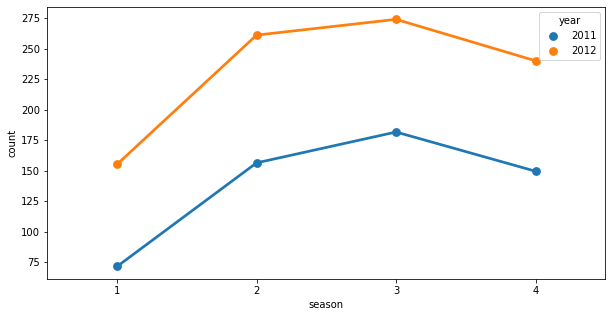

In [53]:
plt.figure(figsize=(10,5))
sns.pointplot(x='season',y='count',hue='year', data=season_year_df)
plt.show()

----------
수요가 가을>여름>겨울>봄 이다.

2011년보다 2012년이 항상 수요가 더 높다.

- season + hour

In [54]:
season_hour_df = pd.DataFrame(bike_df.groupby(['season', 'hour'], sort=True)['count'].mean()).reset_index()

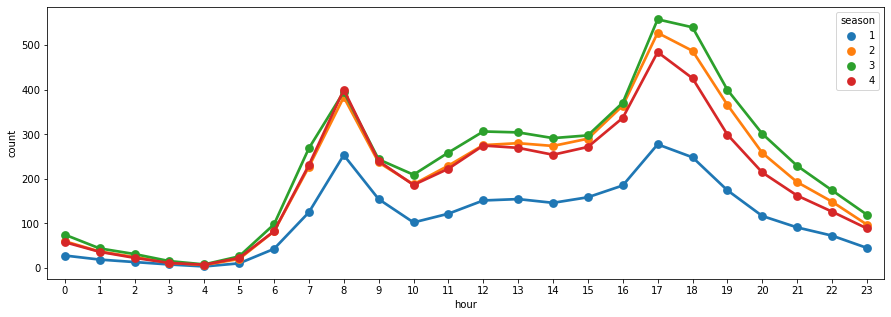

In [55]:
plt.figure(figsize=(15,5))
sns.pointplot(x='hour',y='count',hue='season', data=season_hour_df)
plt.show()

-------------

모든 계절에 동일하게 아침 출근 시간인 7~9사이가 가장 수요가 많다.

그리고 퇴근 시간인 16~19 사이에 수요가 많다.


- hour + month

In [56]:
hour_month_df = pd.DataFrame(bike_df.groupby(['hour', 'month'], sort=True)['count'].mean()).reset_index()

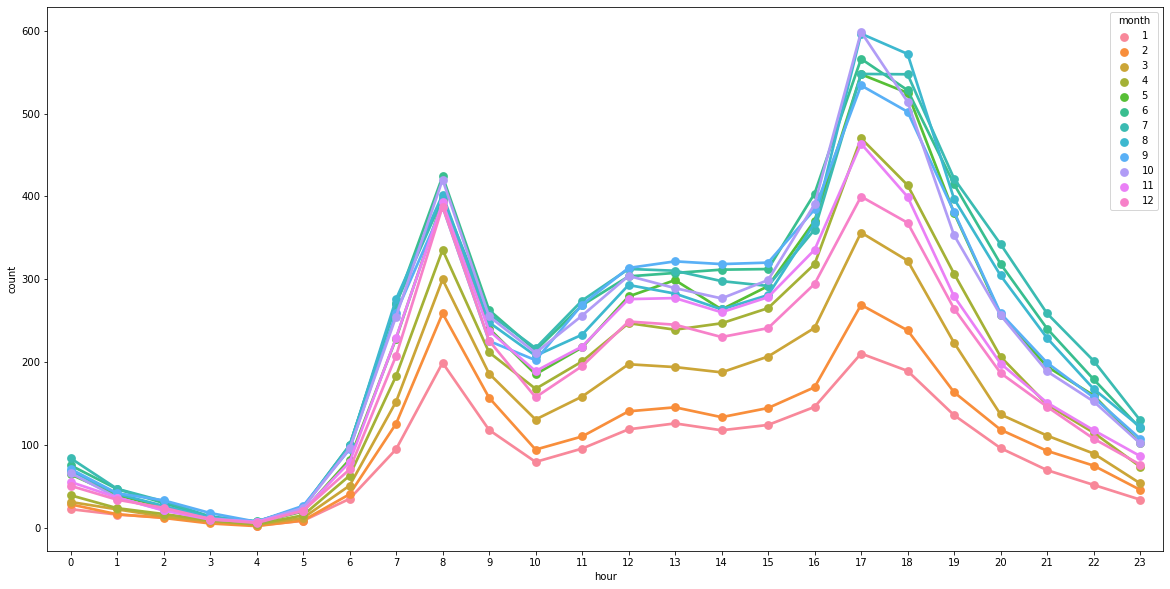

In [57]:
plt.figure(figsize=(20,10))
sns.pointplot(x='hour',y='count',hue='month', data=hour_month_df)
plt.show()

------
모든 month의 hour에 따른 count값은 비슷한 양상을 보이고 있다.

<br>

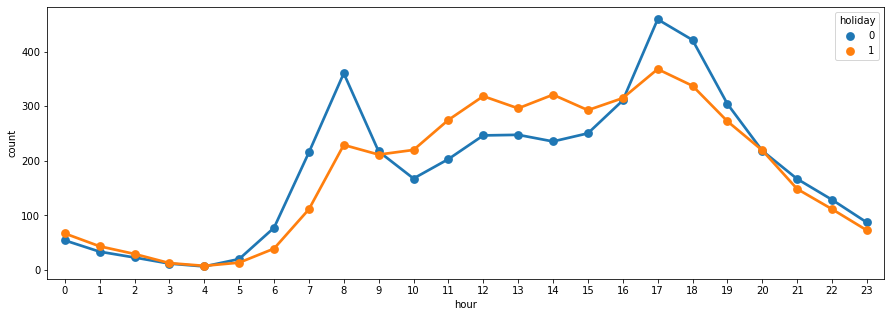

In [58]:
season_holi_df = pd.DataFrame(bike_df.groupby(['hour', 'holiday'], sort=True)['count'].mean()).reset_index()
plt.figure(figsize=(15,5))
sns.pointplot(x='hour',y='count',hue='holiday', data=season_holi_df)
plt.show()

------
holiday일 때는 holiday가 아닐 때보다 출퇴근 시간에 수요가 적고, 낮 시간에는 수요가 더 많다.

<br><br>

# Modeling & Evaluation

### DataFrame 확인

In [59]:
bike_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,log_count,temp_error
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,2.833213,4.555
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,3.713572,4.615
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,3.496508,4.615
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,2.639057,4.555
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,0.693147,4.555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,5.820083,4.115
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,5.488938,2.665
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,5.129899,1.970
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,4.867534,3.485


In [60]:
one_hot_df

,temp,atemp,humidity,windspeed,count,log_count,season_1,season_2,season_3,season_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,14.395,81,0.0000,16,2.833213,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,13.635,80,0.0000,40,3.713572,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,13.635,80,0.0000,32,3.496508,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,14.395,75,0.0000,13,2.639057,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,14.395,75,0.0000,1,0.693147,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,336,5.820083,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
10882,14.76,17.425,57,15.0013,241,5.488938,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
10883,13.94,15.910,61,15.0013,168,5.129899,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
10884,13.94,17.425,61,6.0032,129,4.867534,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [61]:
#필요한 컬럼 추가
one_hot_df['temp_error'] = abs(one_hot_df['temp']-one_hot_df['atemp'])

In [62]:
#outlier 제거
one_hot_df.drop(one_hot_df.loc[one_hot_df['temp_error']>one_hot_df['temp_error'].quantile(0.75)+1].index,inplace=True )

In [63]:
one_hot_df

,temp,atemp,humidity,windspeed,count,log_count,season_1,season_2,season_3,season_4,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,temp_error
0,9.84,14.395,81,0.0000,16,2.833213,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.555
1,9.02,13.635,80,0.0000,40,3.713572,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.615
2,9.02,13.635,80,0.0000,32,3.496508,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.615
3,9.84,14.395,75,0.0000,13,2.639057,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.555
4,9.84,14.395,75,0.0000,1,0.693147,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,336,5.820083,0,0,0,1,...,0,0,0,0,1,0,0,0,0,4.115
10882,14.76,17.425,57,15.0013,241,5.488938,0,0,0,1,...,0,0,0,0,0,1,0,0,0,2.665
10883,13.94,15.910,61,15.0013,168,5.129899,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1.970
10884,13.94,17.425,61,6.0032,129,4.867534,0,0,0,1,...,0,0,0,0,0,0,0,1,0,3.485


### Feature selection

- 모든 컬럼

In [134]:
one_hot_all = one_hot_df.drop(['count','log_count'], axis=1).columns
origin_all = bike_df.drop(['count','log_count'],axis=1).columns

- 일부 컬럼

In [135]:
feature5 = ['atemp', 'humidity', 'holiday', 'temp_error', 'season']
one_hot_5= []
for i in feature5:
    for c in one_hot_df.columns:
        if c.startswith(i) :
            one_hot_5.append(c)

###  Model Building & Results

In [66]:
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n = None, verbose=True):

    if verbose: print(f"-------{model_name}------")
    if model_name == 'LGBM':
        model = LGBMRegressor()
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print(f'5 folds 세트의 평균 RMSE: {np.round(avg_rmse,3)}')
    else:
        for param in params:
            if model_name == "Ridge": model = Ridge(alpha= param)
            elif model_name=="Lasso": model = Lasso(alpha=param)
            elif model_name=='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7) #alpha = a+b값, l1_ratio=a/(a+b)

            neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5)
            avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
            print(f'alpha: {param}, 5 folds 세트의 평균 RMSE: {np.round(avg_rmse,3)}')

    #         #cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    #         model.fit(X_data, y_target)

    #         #alpha에 다른 피처별 회귀 계수를 Series로 변환하고 이를 DF의 칼럼으로 추가
    #         coeff= pd.Series(data=model.coef_, index=X_data.columns)
    #         colname= f'alpha: {param}'
    #         coeff_df[colname]= coeff

#     return coeff_df

In [67]:
models = ['Ridge', 'Lasso', 'ElasticNet','LGBM']

- feature 5

In [136]:
residual_df = []
X_train, X_test, y_train, y_test = train_test_split(bike_df[feature5],bike_df['log_count'],test_size=0.3, random_state=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(one_hot_df[one_hot_5],one_hot_df['log_count'],test_size=0.3, random_state=0)

In [137]:
params=[0.1,1,5,10,100,200,500]
for m in models:
    if m != 'LGBM':
        print("\n#######bike_df#######\n")
        get_linear_reg_eval(m,params,X_train,y_train)
        print("\n#######one_hot_df#######\n")
        get_linear_reg_eval(m,params,X_train_2,y_train_2)
    else:
        print("\n#######bike_df#######\n")
        get_linear_reg_eval(m,None,X_train,y_train)
        print("\n#######one_hot_df#######\n")
        get_linear_reg_eval(m,None,X_train_2,y_train_2)
                            


#######bike_df#######

-------Ridge------
alpha: 0.1, 5 folds 세트의 평균 RMSE: 1.236
alpha: 1, 5 folds 세트의 평균 RMSE: 1.236
alpha: 5, 5 folds 세트의 평균 RMSE: 1.236
alpha: 10, 5 folds 세트의 평균 RMSE: 1.236
alpha: 100, 5 folds 세트의 평균 RMSE: 1.236
alpha: 200, 5 folds 세트의 평균 RMSE: 1.236
alpha: 500, 5 folds 세트의 평균 RMSE: 1.236

#######one_hot_df#######

-------Ridge------
alpha: 0.1, 5 folds 세트의 평균 RMSE: 1.221
alpha: 1, 5 folds 세트의 평균 RMSE: 1.221
alpha: 5, 5 folds 세트의 평균 RMSE: 1.221
alpha: 10, 5 folds 세트의 평균 RMSE: 1.221
alpha: 100, 5 folds 세트의 평균 RMSE: 1.221
alpha: 200, 5 folds 세트의 평균 RMSE: 1.221
alpha: 500, 5 folds 세트의 평균 RMSE: 1.224

#######bike_df#######

-------Lasso------
alpha: 0.1, 5 folds 세트의 평균 RMSE: 1.239
alpha: 1, 5 folds 세트의 평균 RMSE: 1.257
alpha: 5, 5 folds 세트의 평균 RMSE: 1.373
alpha: 10, 5 folds 세트의 평균 RMSE: 1.426
alpha: 100, 5 folds 세트의 평균 RMSE: 1.426
alpha: 200, 5 folds 세트의 평균 RMSE: 1.426
alpha: 500, 5 folds 세트의 평균 RMSE: 1.426

#######one_hot_df#######

-------Lasso------
alpha: 0.1, 5 fold

- feature_all

In [138]:
X_train, X_test, y_train, y_test = train_test_split(bike_df[origin_all],bike_df['log_count'],test_size=0.3, random_state=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(one_hot_df[one_hot_all],one_hot_df['log_count'],test_size=0.3, random_state=0)

In [139]:
params=[0.1,1,5,10,100,200,500]
for m in models:
    if m != 'LGBM':
        print("\n#######bike_df#######\n")
        get_linear_reg_eval(m,params,X_train,y_train)
        print("\n#######one_hot_df#######\n")
        get_linear_reg_eval(m,params,X_train_2,y_train_2)
    else:
        print("\n#######bike_df#######\n")
        get_linear_reg_eval(m,None,X_train,y_train)
        print("\n#######one_hot_df#######\n")
        get_linear_reg_eval(m,None,X_train_2,y_train_2)
                            


#######bike_df#######

-------Ridge------
alpha: 0.1, 5 folds 세트의 평균 RMSE: 1.03
alpha: 1, 5 folds 세트의 평균 RMSE: 1.03
alpha: 5, 5 folds 세트의 평균 RMSE: 1.03
alpha: 10, 5 folds 세트의 평균 RMSE: 1.03
alpha: 100, 5 folds 세트의 평균 RMSE: 1.03
alpha: 200, 5 folds 세트의 평균 RMSE: 1.03
alpha: 500, 5 folds 세트의 평균 RMSE: 1.032

#######one_hot_df#######

-------Ridge------
alpha: 0.1, 5 folds 세트의 평균 RMSE: 0.594
alpha: 1, 5 folds 세트의 평균 RMSE: 0.594
alpha: 5, 5 folds 세트의 평균 RMSE: 0.595
alpha: 10, 5 folds 세트의 평균 RMSE: 0.597
alpha: 100, 5 folds 세트의 평균 RMSE: 0.695
alpha: 200, 5 folds 세트의 평균 RMSE: 0.796
alpha: 500, 5 folds 세트의 평균 RMSE: 0.955

#######bike_df#######

-------Lasso------
alpha: 0.1, 5 folds 세트의 평균 RMSE: 1.051
alpha: 1, 5 folds 세트의 평균 RMSE: 1.086
alpha: 5, 5 folds 세트의 평균 RMSE: 1.359
alpha: 10, 5 folds 세트의 평균 RMSE: 1.426
alpha: 100, 5 folds 세트의 평균 RMSE: 1.426
alpha: 200, 5 folds 세트의 평균 RMSE: 1.426
alpha: 500, 5 folds 세트의 평균 RMSE: 1.426

#######one_hot_df#######

-------Lasso------
alpha: 0.1, 5 folds 세트의 

-------
규제 선형 모델들은 하이퍼 파라미터 튜닝이 필요해보인다.

<br><br><br>

#### 잔차의 분포 확인하기 
정규 분포면 모델은 정확하지만 outlier에 의해 오차가 생긴 것이고, 그렇지 않으면 고려하지 못한 다른 속성 때문일 가능성이 크다.

- bike_df

In [140]:
lgbm_origin = LGBMRegressor()
lgbm_origin.fit(X_train, y_train)

LGBMRegressor()

In [141]:
pred = lgbm_origin.predict(X_test)

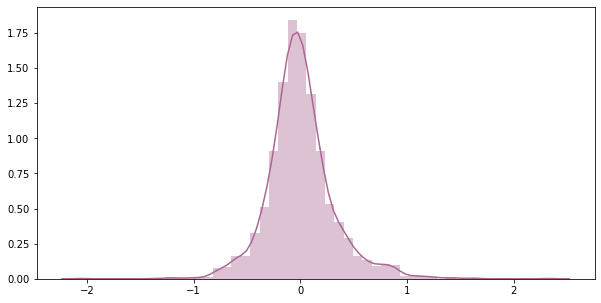

In [142]:
plt.figure(figsize=(10,5))
sns.distplot(pred -np.array(y_test),color = color_dic[3][1])
plt.show()

In [143]:
mean_absolute_error(y_test, pred)

0.2209848919610295

- one_hot_df

In [144]:
lgbm_one = LGBMRegressor()
lgbm_one.fit(X_train_2, y_train_2)
pred = lgbm_one.predict(X_test_2)

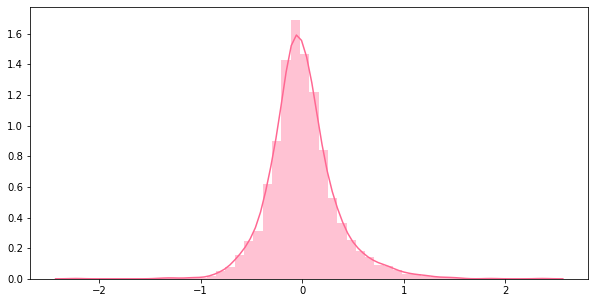

In [145]:
plt.figure(figsize=(10,5))
sns.distplot(pred -np.array(y_test_2),color = color_dic[3][0])
plt.show()

In [146]:
mean_absolute_error(y_test_2, pred)

0.23919439263821485

------
큰 차이는 없지만 one-hot encoding을 적용했을 때의 성능이 더 낮다.

<br><br>

# Submission

In [168]:
def preprocessing1(data):
    #datetime 쪼개기
    data['year'] = data.datetime.apply(lambda x: x.year)
    data['month'] = data.datetime.apply(lambda x: x.month)
    data['day'] = data.datetime.apply(lambda x: x.day)
    data['hour'] = data.datetime.apply(lambda x: x.hour)
    
    #불필요한 컬럼 없애기
    data.drop(['datetime'],axis=1 ,inplace = True)
    
    #컬럼 추가
    data['temp_error'] = abs(data['temp']-data['atemp'])
    
    return data

In [147]:
test = pd.read_csv('./Bike/test.csv',parse_dates = ['datetime'])
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [151]:
test = preprocessing1(test)
test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,temp_error
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0.705
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,2.975
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,2.975
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,2.220
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,2.220
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19,2.220
6489,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20,2.220
6490,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21,2.220
6491,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22,2.975


In [161]:
pred = np.expm1(lgbm_origin.predict(test[origin_all])) #log1p <-> expm1

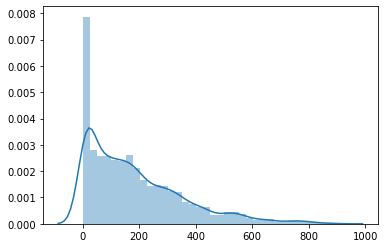

In [163]:
sns.distplot(pred)
plt.show()

In [165]:
submission = pd.read_csv('./Bike/SampleSubmission.csv')
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [167]:
submission['count'] = pred
submission.to_csv('./Bike/submission_1.csv',index=False)

In [210]:
results = pd.DataFrame()
results['Preprocessing'] = None
results['Feature'] =None
results['Model'] = None
results['Score'] = None

In [211]:
results = results.append({'Preprocessing': 1 , 'Feature': 'origin_all', 'Model': 'lgbm(origin_all, log_count)' , 'Score': 0.41609},ignore_index=True)
results

,Preprocessing,Feature,Model,Score
0,1,origin_all,"lgbm(origin_all, log_count)",0.41609


- 결과 기록

In [216]:
origin_results = pd.read_csv('./Bike/results.csv')
origin_results

,Preprocessing,Feature,Model,Score
0,1,origin_all,"lgbm(origin_all, log_count)",0.41609


In [217]:
origin_results = pd.concat([origin_results, results]) #기록 추가

In [215]:
#origin_results.to_csv('./Bike/results.csv',index=False)